In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import scipy as sp
import pyccl as ccl
import theano
import theano.tensor as tt
import os
import utils
from make_data import MakeData
from scipy.linalg import block_diag
theano.config.exception_verbosity='high'
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Settings

In [2]:
z_max = 1100
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

DESI = data_class.get_DESI(new=True, mode=None)
H_DESI = data_class.get_DESI(new=True, mode='H')
dA_DESI = data_class.get_DESI(new=True, mode='dA')
fs8_DESI = data_class.get_DESI(new=True, mode='fs8')
WFIRST = data_class.get_WFIRST(new=True)
CC = data_class.get_CC(new=True)
DSS = data_class.get_DSS(new=True)
BOSS = data_class.get_BOSS(new=True)
eBOSS = data_class.get_eBOSS(new=True)
Wigglez = data_class.get_Wigglez(new=True)
DS17 = data_class.get_DS17(new=True)
CMB = data_class.get_CMB(new=True)
FCMB = data_class.get_FCMB(new=True)

In [3]:
n_samples = 100
n_tune = 100
datadict = {'DESI': DESI,
            'H_DESI': H_DESI,
            'dA_DESI': dA_DESI,
            'fs8_DESI': fs8_DESI,
            'WFIRST': WFIRST,
            'CC': CC,
            'DS17': DS17, 
            'BOSS': BOSS,
            'eBOSS': eBOSS,
            'Wigglez': Wigglez,
            'DSS': DSS, #}#,
            'CMB': CMB, 
            'FCMB': FCMB}

data_comb = 'DESI' # All, All_CMB, SDSS, SDSS_CMB, Add, Add_CMB
data_combs = {'All': ['CC', 'DS17', 'BOSS', 'eBOSS', 'Wigglez', 'DSS'],
             'All_CMB': ['CC', 'DS17', 'BOSS', 'eBOSS', 'Wigglez', 'DSS', 'CMB'],
             'All_FCMB': ['CC', 'DS17', 'BOSS', 'eBOSS', 'Wigglez', 'DSS', 'FCMB'],
             'SDSS': ['BOSS', 'eBOSS'],
             'SDSS_CMB': ['BOSS', 'eBOSS', 'CMB'],
             'Add': ['CC', 'DS17', 'Wigglez', 'DSS'],
             'Add_CMB': ['CC', 'DS17', 'Wigglez', 'DSS', 'CMB'],
             'DESI_CMB': ['DESI', 'CMB'],
             'DESI': ['DESI'], 
             'CC': ['CC']}

datasets = data_combs[data_comb]

need_dM = ['DESI', 'dA_DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DS17', 'CMB', 'FCMB']
need_fs8 = ['DESI', 'fs8_DESI', 'BOSS', 'eBOSS', 'Wigglez', 'DSS']
need_rd = ['BOSS', 'eBOSS', 'CMB']

if any(dataset in datasets for dataset in need_dM):
    get_dM=True 
else:
    get_dM=False
    
if any(dataset in datasets for dataset in need_fs8):
    get_fs8=True
else:
    get_fs8=False
    
if any(dataset in datasets for dataset in need_rd):
    get_rd = True
else:
    get_rd = False

# Plotting

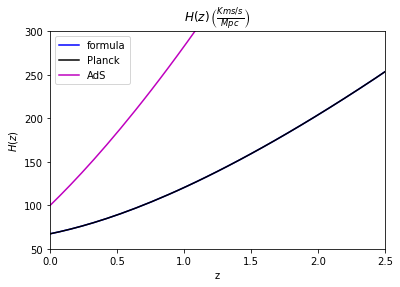

In [4]:
plt.plot(z_arr, data_class.H_arr, "b", label='formula')
plt.plot(z_planck, Planck['Hkms_arr'], "k", label='Planck')
plt.plot(z_arr, 100*np.sqrt((1+z_arr)**3), "m", label='AdS')

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

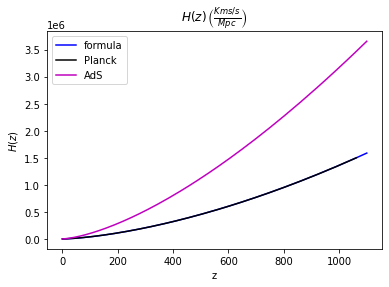

In [5]:
plt.plot(z_arr, data_class.H_arr, "b", label='formula')
plt.plot(z_planck, Planck['Hkms_arr'], "k", label='Planck')
plt.plot(z_arr, 100*np.sqrt((1+z_arr)**3), "m", label='AdS')

# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

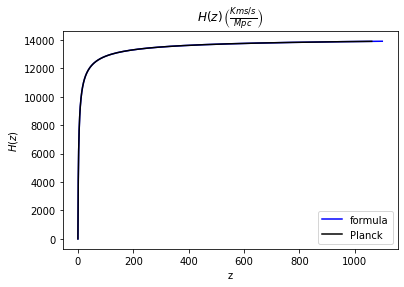

In [6]:
plt.plot(z_arr, data_class.dM_arr, "b", label='formula')
plt.plot(z_planck, Planck['dM_arr'], "k", label='Planck')

# axis labels and title
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

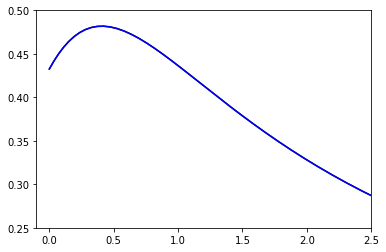

In [7]:
plt.plot(z_planck, Planck['fs8_arr'], "k", label='Planck')
plt.plot(z_arr, data_class.fs8_arr, "b", label='formula')
plt.xlim(-0.1, 2.5)
plt.ylim(0.25, 0.5)
plt.show()

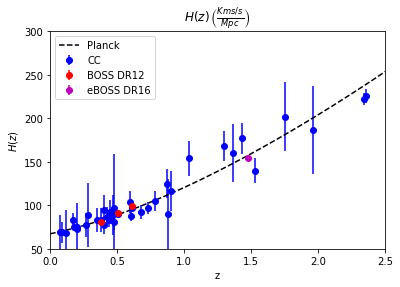

In [8]:
plt.plot(z_planck, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
#plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS DR16')


# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_data.pdf')  

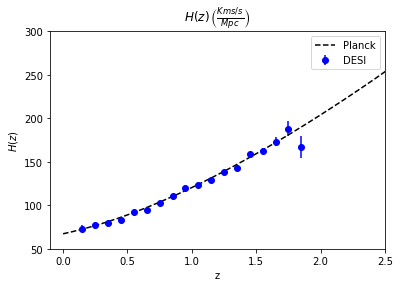

In [9]:
plt.plot(z_planck, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(H_DESI['z'], H_DESI['data'], yerr = H_DESI['err'], fmt='bo', label='DESI')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_forecast.pdf')  

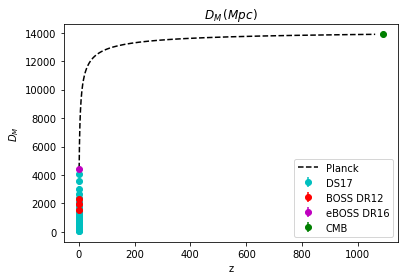

In [10]:
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.2)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS DR16')
plt.errorbar(CMB['z'], (1/CMB['data'])*(100*CMB['rd']), yerr=(1/CMB['err'])*1/(100*CMB['rd']), fmt='go', label='CMB')

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')  

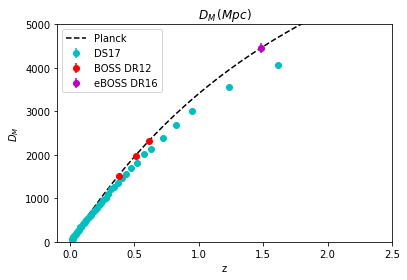

In [11]:
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.2)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS DR16')

# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0, 5000)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_data.pdf')  

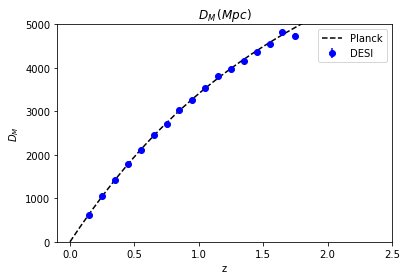

In [12]:
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], (1+DESI['z'])*dA_DESI['data'], yerr=dA_DESI['err'], fmt='bo', label='DESI')

# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0, 5000)
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_forecast.pdf')  

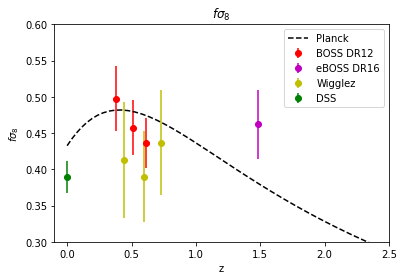

In [13]:
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS DR16')
plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')


# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0.3, 0.6)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_data.pdf')  

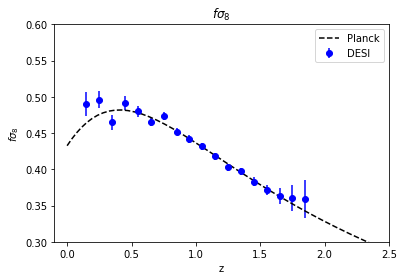

In [14]:
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(DESI['z'], fs8_DESI['data'], yerr=fs8_DESI['err'], fmt='bo', label='DESI')

# axis labels and title
plt.xlim(-0.1, 2.5)
plt.ylim(0.3, 0.6)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();
os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_forecast.pdf')  

In [15]:
data = np.array([])
data_cov = np.array([])
for dataset_name in datasets:
    dataset = datadict[dataset_name]
    data = np.concatenate([data, dataset['data']])
    data_cov = block_diag(data_cov, dataset['cov'])
data_cov = data_cov[1:]

In [16]:
with pm.Model() as model:
    ℓ = pm.Uniform("ℓ", 0.001, 7) 
    η = 0.5 #pm.HalfNormal("η", sigma=0.5) 
    H0 = data_class.H0
    wm0 = pm.Uniform("wm0", 0., 0.45) 
    wm0_geo = data_class.wm0
    wr0 = data_class.wr0
    wL0 = pm.Deterministic("wL0", (H0/100)**2-wm0_geo-wr0) 
    gp_cov = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    #Mean of the gp
    H = pm.Deterministic('H', 100*tt.sqrt(wm0_geo*(1+z_arr)**3+wr0*(1+z_arr)**4+wL0))
    #H = pm.Deterministic('H', 100*tt.sqrt((1+z_arr)**3))
    
    #Set up Gaussian process
    DH_gp = gp.prior("DH_gp", X=x_arr[:, None]) 
    H_gp = pm.Deterministic("H_gp", tt.as_tensor_variable(H*(1+DH_gp)))
    H0_gp = pm.Deterministic("H0_gp", tt.as_tensor_variable(H_gp[0]))
    
    if get_dM:
        dH_gp = pm.Deterministic("dH", tt.as_tensor_variable((c/1000)/H_gp))
        dM_rec_gp = tt.zeros(len(z_arr)+1)
        dM_rec_gp = tt.inc_subtensor(dM_rec_gp[1:],
                  tt.as_tensor_variable(dx*tt.cumsum(dH_gp*(1+z_arr))))
        dM_trap_gp = tt.as_tensor_variable(0.5*(dM_rec_gp[1:]+dM_rec_gp[:-1])-0.5*dM_rec_gp[1])
        dM_gp = pm.Deterministic('dM_gp', dM_trap_gp)
        #dM_gp = pm.Deterministic('dM_gp', dM_rec_gp[:-1])
        dA_gp = pm.Deterministic('dA_gp', dM_gp/(1+z_arr))
        dL_gp = pm.Deterministic('dL_gp', dM_gp*(1+z_arr))
        
    if get_rd:
        #https://arxiv.org/pdf/2106.00428.pdf
        #wb0 = data_class.wb0
        wb0 =  pm.Uniform("wb0", 0.022, 0.023)
        a1 = 0.00785436
        a2 = 0.177084
        a3 = 0.00912388
        a4 = 0.618711
        a5 = 11.9611
        a6 = 2.81343
        a7 = 0.784719
        #rd_gp = CMB['rd']
        rd_gp = pm.Deterministic("rd_gp", 1/(a1*wb0**a2+a3*wm0_geo**a4+a5*wb0**a6*wm0_geo**a7))  
        
    if get_fs8:
        #s80 = data_class.s80
        s80 = pm.Normal("s80", 0.8, 0.5)
        E = H_gp/H_gp[0]
        Om = wm0*(100/H0)**2
        xx = x_arr[::-1]
        ee = E[::-1]
        aa = np.exp(-xx)
        dx = np.mean(np.diff(xx))

        nz = len(aa)
        dd = tt.zeros(nz)
        yy = tt.zeros(nz)
        dd = tt.inc_subtensor(dd[0], aa[0])
        yy = tt.inc_subtensor(yy[0], aa[0]**3*E[0])

        for i in range(nz-1):
            A0 = -1.5*Om/(aa[i]*ee[i])
            B0 = -1./(aa[i]**2*ee[i])
            A1 = -1.5*Om/(aa[i+1]*ee[i+1])
            B1 = -1./(aa[i+1]**2*ee[i+1])
            yy = tt.inc_subtensor(yy[i+1], (1+0.5*dx**2*A0*B0)*yy[i]+0.5*(A0+A1)*dx*dd[i])
            dd = tt.inc_subtensor(dd[i+1],0.5*(B0+B1)*dx*yy[i]+(1+0.5*dx**2*A0*B0)*dd[i])
        
        y = tt.as_tensor_variable(yy[::-1])
        d = tt.as_tensor_variable(dd[::-1])
        
        fs8_gp = pm.Deterministic('fs8_gp', s80*y/(a_arr**2*E*d[0]))
        s8_gp = pm.Deterministic('s8_gp', s80*d/d[0])
    
    theory = tt.as_tensor_variable([])

In [ ]:
if 'DESI' in datasets:
    print('Adding DESI')
    with model:
        DESI_H = pm.Deterministic('DESI_H',
                 tt.as_tensor_variable(H_gp[DESI['idx']]+(H_gp[DESI['idx']+1]-H_gp[DESI['idx']])*DESI['U']))
        DESI_dA = pm.Deterministic('DESI_dA',
                  tt.as_tensor_variable(dA_gp[DESI['idx']]+(dA_gp[DESI['idx']+1]-dA_gp[DESI['idx']])*DESI['U']))
        DESI_fs8 = pm.Deterministic('DESI_fs8',
                   tt.as_tensor_variable(fs8_gp[DESI['idx']]+(fs8_gp[DESI['idx']+1]-fs8_gp[DESI['idx']])*DESI['U']))
        theory = tt.concatenate([theory, DESI_H, DESI_dA, DESI_fs8])
        
if 'H_DESI' in datasets:
    print('Adding H_DESI')
    with model:
        DESI_H = pm.Deterministic('DESI_H',
                 tt.as_tensor_variable(H_gp[H_DESI['idx']]+(H_gp[H_DESI['idx']+1]-H_gp[H_DESI['idx']])*H_DESI['U']))
        theory = tt.concatenate([theory, DESI_H])
        
if 'WFIRST' in datasets:
    print('Adding WFIRST')
    with model:
        WFIRST_E = pm.Deterministic('WFIRST_E',
                   tt.as_tensor_variable(E_gp[WFIRST['idx']]+(E_gp[WFIRST['idx']+1]-E_gp[WFIRST['idx']])*WFIRST['U']))
        theory = tt.concatenate([theory, WFIRST_E])

if 'CC' in datasets:
    print('Adding CCs')
    with model:
        CC_H = pm.Deterministic("CC_H",
               tt.as_tensor_variable(H_gp[CC['idx']]+(H_gp[CC['idx']+1]-H_gp[CC['idx']])*CC['U']))
        theory = tt.concatenate([theory, CC_H])
        
if 'DS17' in datasets:
    print('Adding Pantheon')
    with model:
        M = pm.Normal('M', mu=-19.0, sigma=3)
        DS17_dL = tt.as_tensor_variable(dL_gp[DS17['idx']]+(dL_gp[DS17['idx']+1]-dL_gp[DS17['idx']])*DS17['U'])
        DS17_u = pm.Deterministic("DS17_dL",
                 tt.as_tensor_variable(5*tt.log10(DS17_dL)+25+M))
        theory = tt.concatenate([theory, DS17_u])
        
if 'BOSS' in datasets:
    print('Adding BOSS')
    with model:
        B_H = tt.as_tensor_variable(H_gp[BOSS['idx']]+(H_gp[BOSS['idx']+1]-H_gp[BOSS['idx']])*BOSS['U'])
        B_dM = tt.as_tensor_variable(dM_gp[BOSS['idx']]+(dM_gp[BOSS['idx']+1]-dM_gp[BOSS['idx']])*BOSS['U'])
        B_fs8 = pm.Deterministic("B_fs8", 
                   tt.as_tensor_variable(fs8_gp[BOSS['idx']]+(fs8_gp[BOSS['idx']+1]-fs8_gp[BOSS['idx']])*BOSS['U']))
        #Get alpha_perp and alpha_para 
        B_para = pm.Deterministic("B_para", B_H*rd_gp/BOSS['rd'])
        B_perp = pm.Deterministic("B_perp", B_dM*BOSS['rd']/rd_gp)
        theory = tt.concatenate([theory, B_para, B_perp, B_fs8])
        
if 'eBOSS' in datasets:
    print('Adding eBOSS')
    with model:
        eB_dH = tt.as_tensor_variable(dH_gp[eBOSS['idx']]+(dH_gp[eBOSS['idx']+1]-dH_gp[eBOSS['idx']])*eBOSS['U'])
        eB_dM = tt.as_tensor_variable(dM_gp[eBOSS['idx']]+(dM_gp[eBOSS['idx']+1]-dM_gp[eBOSS['idx']])*eBOSS['U'])
        eB_fs8 = pm.Deterministic("eB_fs8", 
                   tt.as_tensor_variable(fs8_gp[eBOSS['idx']]+(fs8_gp[eBOSS['idx']+1]-fs8_gp[eBOSS['idx']])*eBOSS['U']))
        eB_para = pm.Deterministic("eB_para", eB_dH/rd_gp)# eBOSS['rd'])
        eB_perp = pm.Deterministic("eB_perp", eB_dM/rd_gp)# eBOSS['rd'])
        theory = tt.concatenate([theory, eB_para, eB_perp, eB_fs8])

if 'Wigglez' in datasets:
    print('Adding Wigglez')
    with model:
        Wigglez_fs8 = pm.Deterministic("Wigglez_fs8",
                    tt.as_tensor_variable(fs8_gp[Wigglez['idx']]+(fs8_gp[Wigglez['idx']+1]-fs8_gp[Wigglez['idx']])*Wigglez['U']))
        theory = tt.concatenate([theory, Wigglez_fs8])

if 'DSS' in datasets:
    print('Adding DSS')
    with model:
        DSS_fs8 = pm.Deterministic("fs8_eBOSS", tt.as_tensor_variable(fs8_gp[DSS['idx']]))
        theory = tt.concatenate([theory, DSS_fs8])

if 'CMB' in datasets:
    print('Adding CMB')
    with model:
        dM_star = tt.as_tensor_variable(dM_gp[CMB['idx']]+(dM_gp[CMB['idx']+1]-dM_gp[CMB['idx']])*CMB['U'])
        t100 = pm.Deterministic('t100', 100*rd_gp/dM_star) 
        theory = tt.concatenate([theory, t100])
        
if 'FCMB' in datasets:
    print('Adding FCMB')
    with model:
        FCMB_dM = pm.Deterministic('FCMB_dM',
                  tt.as_tensor_variable(dM_gp[FCMB['idx']]+(dM_gp[FCMB['idx']+1]-dM_gp[FCMB['idx']])*FCMB['U']))
        theory = tt.concatenate([theory, FCMB_dM])
        
with model:
    lkl= pm.MvNormal("lkl", mu=theory, cov=data_cov, observed=data)
    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune)#, step=pm.Metropolis())


Adding DESI


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s80, DH_gp_rotated_, wm0, H0, ℓ]


In [ ]:
pm.summary(trace)['r_hat'][["ℓ","η"]]

In [ ]:
pm.summary(trace)['mean'][["ℓ","η"]]

In [ ]:
pm.summary(trace)['mean'][["wm0", 's80']]

In [ ]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [ ]:
DHz = np.array(trace.posterior["DH_gp"])
DHz = DHz.reshape(-1, DHz.shape[-1])
DH_m, DH_s = get_m_s(DHz)

In [ ]:
plt.plot(z_arr,  DH_m, color ='b')
plt.fill_between(z_arr, DH_m+DH_s,
                 DH_m-DH_s, color='b', alpha=.5)
plt.xscale('log')
plt.xlim(0, 1110)
plt.title('$\delta$H(z)')
plt.show()

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["DH_gp"][0, :, :], z_arr[:, None])
plt.plot(z_arr, np.zeros_like(z_arr), 'k--')

# axis labels and title
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("DH(z)")
plt.title("DH(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
ax.plot(z_planck, Planck['Hkms_arr'], "k--", label=r'$CLASS$')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
plt.plot(z_arr, data_class.H_arr, 'b-.', label='formula')

if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')
if 'DESI' in datasets:
    plt.errorbar(H_DESI['z'], H_DESI['data'], yerr = H_DESI['err'], fmt='bo', label='DESI')

# axis labels and title
#plt.xscale('log')
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
ax.plot(z_planck, Planck['Hkms_arr'], "k--", label=r'$CLASS$')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
plt.plot(z_arr, data_class.H_arr, 'b-.', label='formula')

if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')
if 'DESI' in datasets:
    plt.errorbar(H_DESI['z'], H_DESI['data'], yerr = H_DESI['err'], fmt='bo', label='DESI')

# axis labels and title
#plt.xscale('log')
plt.xlim(0, 10)
plt.ylim(50, 1000)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
plt.plot(z_arr, data_class.H_arr, 'b-.', label='formula')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'FCMB' in datasets:
    plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')
if 'DESI' or 'H_DESI' in datasets:
    plt.errorbar(H_DESI['z'], H_DESI['data'], yerr = H_DESI['err'], fmt='bo', label='DESI')

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
X_new = np.linspace(0, np.log(1+1100), res)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    H_pred = gp.conditional("H_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["H_pred"], samples=2000)

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

plot_gp_dist(ax, pred_samples["H_pred"], X_new)
plt.show()

In [ ]:
# plot the results
data_class = MakeData(1100, 200 , path)
Planck = data_class.Planck
Planck['Hkms_arr']


fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(data_class)
plot_gp_dist(ax, Planck['Hkms_arr']*(1+pred_samples["H_pred"][:, :-1]), np.exp(X_new[:-1])-1)
plt.show()

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

plot_gp_dist(ax, trace.posterior["dM_gp"][0, :, :], z_arr[:, None])

plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.plot(z_arr, data_class.dM_arr, 'b-.', label='formula')

if 'DS17' in datasets:
    plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.49)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS')
if 'CMB' in datasets:
    plt.errorbar(CMB['z'], (1/CMB['data'])*(100*CMB['rd']), yerr=(1/CMB['err'])*1/(100*CMB['rd']), fmt='go', label='CMB')
if 'DESI' in datasets:
    plt.errorbar(dA_DESI['z'], dA_DESI['data']*(1+dA_DESI['z']), yerr = dA_DESI['err'], fmt='bo', label='DESI')
    
# axis labels and title
#plt.xscale('log')
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("dM(z)")
plt.title("dM(z)")
plt.legend();

In [ ]:
rd_gp = np.mean(np.array(trace.posterior["rd_gp"]).flatten())

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dM_gp"][0, :, :], z_arr[:, None])

plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.plot(z_arr, data_class.dM_arr, 'b-.', label='formula')

if 'DS17' in datasets:
    plt.errorbar(DS17['z'], (10**((DS17['data']-25+19.49)/5))/(1+DS17['z']),
             yerr=(10**(DS17['err']/5))/(1+DS17['z']), fmt='co', label='DS17')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['perp_data'], yerr=BOSS['perp_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['perp_data']*eBOSS['rd'], yerr=np.array([0.79])*eBOSS['rd'], fmt='mo', label='eBOSS')
if 'CMB' in datasets:
    plt.errorbar(CMB['z'], (1/CMB['data'])*(100*rd_gp), yerr=(1/CMB['err'])*1/(100*CMB['rd']), fmt='go', label='CMB')
if 'DESI' in datasets:
    plt.errorbar(dA_DESI['z'], dA_DESI['data']*(1+dA_DESI['z']), yerr = dA_DESI['err'], fmt='bo', label='DESI')
if 'FCMB' in datasets:
    plt.errorbar(FCMB['z'], FCMB['data'], yerr=FCMB['err'], fmt='go', label='FCMB')
    
# axis labels and title
#plt.xscale('log')
plt.xlabel("z")
plt.ylabel("dM(z)")
plt.title("dM(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp"][0, :, :],
             z_arr[:, None])
plt.plot(z_arr, data_class.fs8_arr, 'b-.', label='formula')

plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS')
if 'Wigglez' in datasets:
    plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
if 'DSS' in datasets:
    plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')
if 'DESI' in datasets:
    plt.errorbar(fs8_DESI['z'], fs8_DESI['data'], yerr = fs8_DESI['err'], fmt='bo', label='DESI')    


# axis labels and title
plt.xlim(-.1, 2.5)
plt.ylim(0.2, 0.85)
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp"][0, :, :],
             z_arr[:, None])

plt.plot(z_arr, data_class.fs8_arr, 'b-.', label='formula')
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['fs8_data'], yerr=BOSS['fs8_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], eBOSS['fs8_data'], yerr=eBOSS['fs8_err'], fmt='mo', label='eBOSS')
if 'Wigglez' in datasets:
    plt.errorbar(Wigglez['z'], Wigglez['data'], yerr=Wigglez['err'], fmt='yo', label='Wigglez')
if 'DSS' in datasets:
    plt.errorbar(DSS['z'], DSS['data'], yerr=DSS['err'], fmt='go', label='DSS')
if 'DESI' in datasets:
    plt.errorbar(fs8_DESI['z'], fs8_DESI['data'], yerr = fs8_DESI['err'], fmt='bo', label='DESI')   


# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [ ]:
#Save
filename = data_comb
path = filename+'_fixed_eta_{}_{}'.format(n_samples, n_tune)

n = 0.5 #np.array(trace.posterior["η"]).flatten()
l = np.array(trace.posterior["ℓ"]).flatten()
DHz = np.array(trace.posterior["DH_gp"])
DHz = DHz.reshape(-1, DHz.shape[-1])
Hz =np.array(trace.posterior["H_gp"])
Hz = Hz.reshape(-1, Hz.shape[-1])
H0 = np.array(trace.posterior["H0_gp"]).flatten()
omega_m = np.array(trace.posterior["wm0"]).flatten()
#omega_L = np.array(trace.posterior["wL0"]).flatten()


if get_dM:
    dMz = np.array(trace.posterior["dM_gp"])
    dMz = dMz.reshape(-1, dMz.shape[-1])
else:
    dMz = None

if get_rd:
    rd = np.array(trace.posterior["rd_gp"]).flatten()
    omega_b = np.array(trace.posterior["wb0"]).flatten()
else:
    rd = None
    Omega_b = None
    
if get_fs8:
    s8z = np.array(trace.posterior["s8_gp"])
    s8z = s8z.reshape(-1, s8z.shape[-1])
    fs8z = np.array(trace.posterior["fs8_gp"])
    fs8z = fs8z.reshape(-1, fs8z.shape[-1])
    s80 = np.array(trace.posterior["s80"]).flatten()
    S80 = s80*np.sqrt((omega_m/(H0/100)**2)/0.3)
else: 
    s8z = None 
    fs8z = None
    s80 = None
    S80 = None

if 'DS17' in datasets:
    M = np.array(trace.posterior["M"]).flatten()
else:
    M = None

os.mkdir(path)
np.savez(os.path.join(path,'samples.npz'), 
         z_arr = z_arr,
         n=n,
         l=l,
         DHz = DHz,
         Hz=Hz,
         dMz=dMz,
         s8z=s8z,
         fs8z=fs8z,
         H0=H0,
         omega_m=omega_m,
         omega_b=omega_b,
         #omega_L=omega_L,
         rd=rd,
         s80=s80,
         S80=S80)

In [ ]:
data_class.wL0

In [ ]:
(data_class.H0/100)**2-data_class.wm0-data_class.wr0